# Library Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

from base import gc_collect_all, setdiff
from filesystem_utils import mkdir
from graph import abline
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [2]:
gc_collect_all()

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
def return_unique_columns(data):
    unique_info = data.nunique()
    unique_cols = unique_info[unique_info==1].index.tolist()
    return unique_cols

In [5]:
class CFG:
    SEED = 42
    N_SPLITS = 5
    TARGET = 'price(원/kg)'
    KEY_FEATURES = ['item','corporation','location']

<br></br>

# Data

## Data Load

In [6]:
# item:
#     TG : 감귤
#     BC : 브로콜리
#     RD : 무
#     CR : 당근
#     CB : 양배추

In [7]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
trade_df = pd.read_csv('./data/international_trade.csv')

In [8]:
print(train_df.shape)
train_df.head()

(59397, 7)


,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [9]:
print(test_df.shape)
test_df.head()

(1092, 5)


,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [10]:
print(trade_df.shape)
trade_df.head()

(1274, 7)


,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


<br>

## Preprocessing

In [11]:
def add_week(weekend):
    week = 1
    week_list = []
    for weekend in weekend:
        if weekend==1:
            week+=1
        week_list.append(week)
    return week_list

In [12]:
def preprocessing(data):
    d = data.copy()
    
    d = d.sort_values(CFG.KEY_FEATURES).reset_index(drop=True)
    
    # (1) datetime format
    d['timestamp'] = d['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
    
    # (2) delete unuse features
    unuse_features = ['ID','supply(kg)']
    unuse_features = list(set(d.columns)&set(unuse_features))
    d.drop(unuse_features,axis=1,inplace=True)

    return d

In [13]:
def merge_trade_data(data,trade_data):
    d, td = data.copy(), trade_data.copy()
    
    ### trade data preprocessing
    
    # # (1) 흑자여부
    td.drop('무역수지',axis=1,inplace=True)

    # (2) 품목명 수정 및 필요없는 품목 정보 제거
    replace_dict = {
        '감귤': 'TG',
        '꽃양배추와 브로콜리(broccoli)': 'BC',
        '당근': 'CR',
        '순무': 'RD',
        '양배추': 'CB',
    }
    td['품목명'] = td['품목명'].map(replace_dict)
    td.dropna(subset=['품목명'], inplace=True)
    
    ### merge data
    d['기간'] = [str(t)[:7] for t in d['timestamp']]
    merged = pd.merge(d,td.rename(columns={'품목명':'item'}),how='left',on=['기간','item'])
    merged.drop('기간',axis=1,inplace=True)
    
    # 2023년 3월 데이터는 trade 데이터에 없으므로 가장 최근의 값으로 채워줌
    merged.ffill(inplace=True)
    
    return merged

In [14]:
def feature_engineering(data):
    d = data.copy()
    
    # (1) date columns
    d['year']       = d.timestamp.dt.year
    d['month']      = d.timestamp.dt.month
    d['day']        = d.timestamp.dt.day
    d['weekday']    = d.timestamp.dt.weekday
    d['weekend']    = d.timestamp.dt.weekday.isin([5,6]).astype(int)
    d['week']       = add_week(d['weekend'])

    # (2) is holiday & is dayoff
    holiday_list = get_holiday(d['year'].unique())
    d['is_holiday'] = d.timestamp.isin(holiday_list).astype(int)
    d['is_dayoff']  = ((d.is_holiday==1) | (d.weekend==1)).astype(int)
    
    # (3) 무역수지, 흑자여부 추가
    d['무역수지'] = d['수출 금액'] - d['수입 금액']
    d['흑자여부'] = np.where(d['무역수지']>0,1,0)
    
    return d

In [15]:
# from copy import deepcopy
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import SimpleImputer, IterativeImputer

# def imputation(train_data,test_data,method):
#     if method in ['mean','median']:
#         base_imputer = SimpleImputer(missing_values=np.nan, strategy=method)
#     elif method=='mice':
#         base_imputer = IterativeImputer(random_state=CFG.SEED)
#     else:
#         raise ValueError(f"Unknown method={method}")
    
#     numerical_cols = train_data.select_dtypes(include=[int,float]).columns.tolist()
#     numerical_cols = list(set(numerical_cols)-set([CFG.TARGET]))
    
#     train_list = []
#     test_list = []
#     for (item,corporation,location),tr in tqdm(train_data.groupby(['item','corporation','location'])):
#         te = test_data[(test_data['item']==item) & (test_data['corporation']==corporation) & (test_data['location']==location)]
#         imputer = deepcopy(base_imputer)
#         tr[numerical_cols] = imputer.fit_transform(tr[numerical_cols])
#         train_list.append(tr)
#         if len(te)>0:
#             te[numerical_cols] = imputer.transform(te[numerical_cols])
#             test_list.append(te)
        
#     new_train = pd.concat(train_list,axis=0)
#     new_test = pd.concat(test_list,axis=0)
    
#     return new_train.sort_index(), new_test.sort_index()

In [16]:
train_df = preprocessing(train_df)
train_df = merge_trade_data(train_df, trade_df)
train_df = feature_engineering(train_df)

test_df = preprocessing(test_df)
test_df = merge_trade_data(test_df, trade_df)
test_df = feature_engineering(test_df)

In [17]:
train_df.head()

,timestamp,item,corporation,location,price(원/kg),수출 중량,수출 금액,수입 중량,수입 금액,year,month,day,weekday,weekend,week,is_holiday,is_dayoff,무역수지,흑자여부
0,2019-01-01,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,1,1,0,1,1,1,-562.0,0
1,2019-01-02,BC,A,J,0.0,160.0,1.0,638913.0,563.0,2019,1,2,2,0,1,0,0,-562.0,0
2,2019-01-03,BC,A,J,2559.0,160.0,1.0,638913.0,563.0,2019,1,3,3,0,1,0,0,-562.0,0
3,2019-01-04,BC,A,J,2425.0,160.0,1.0,638913.0,563.0,2019,1,4,4,0,1,0,0,-562.0,0
4,2019-01-05,BC,A,J,2097.0,160.0,1.0,638913.0,563.0,2019,1,5,5,1,2,0,1,-562.0,0


<br></br>

# EDA

In [18]:
# (1) key별 건수
train_df.groupby(CFG.KEY_FEATURES).size().head()

item  corporation  location
BC    A            J           1523
                   S           1523
      B            J           1523
                   S           1523
      C            J           1523
dtype: int64

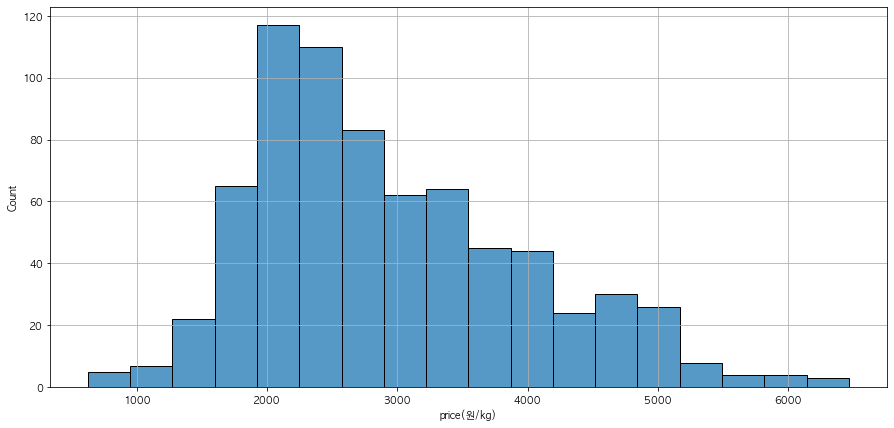

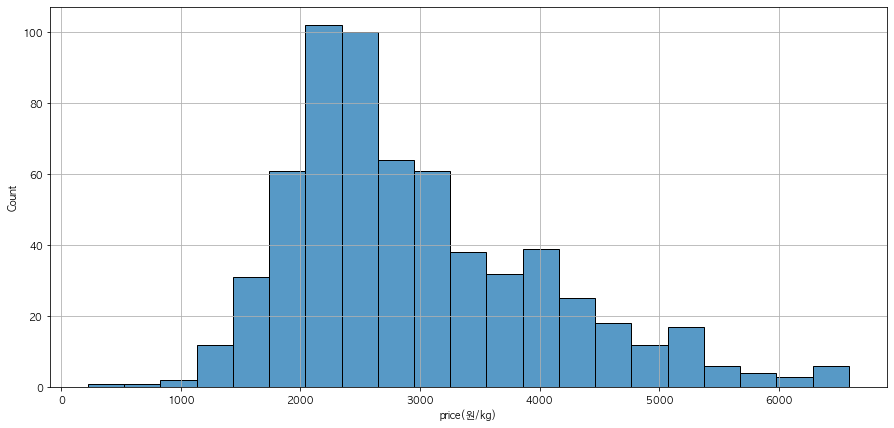

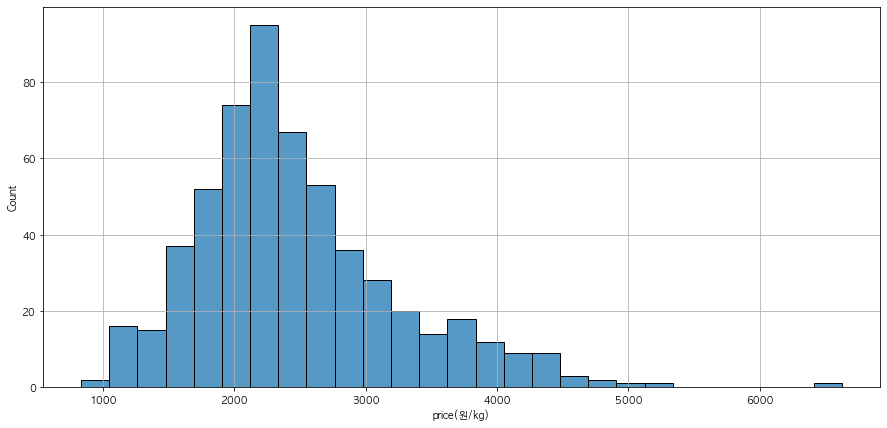

In [19]:
# (2) 품목/법인/지역에 따른 가격 히스토그램
# train_df.groupby(CFG.KEY_FEATURES)[CFG.TARGET].agg(Min=np.min,Max=np.max)
for i,(idx,d) in enumerate(train_df.groupby(CFG.KEY_FEATURES)):
    if i<3:
        target = d[CFG.TARGET]
        target = target[target!=0]
        
        plt.figure(figsize=(15,7))
        sns.histplot(target)
        plt.grid()
        plt.show()

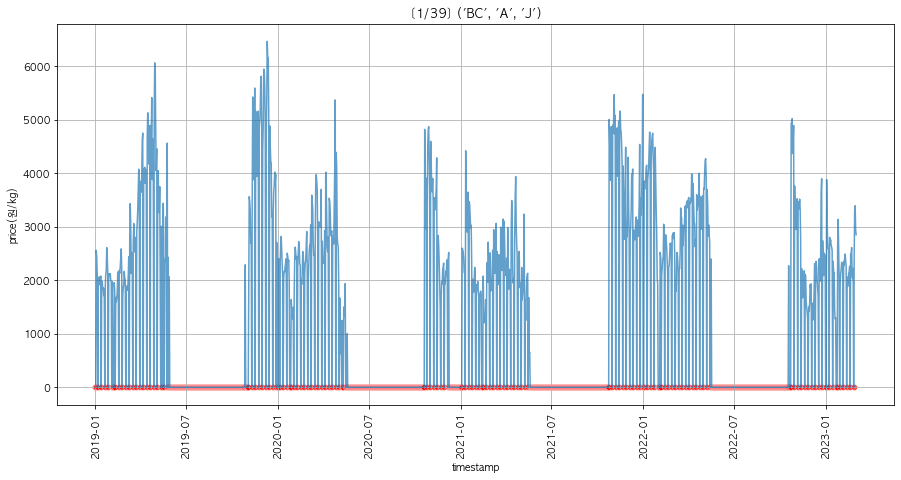

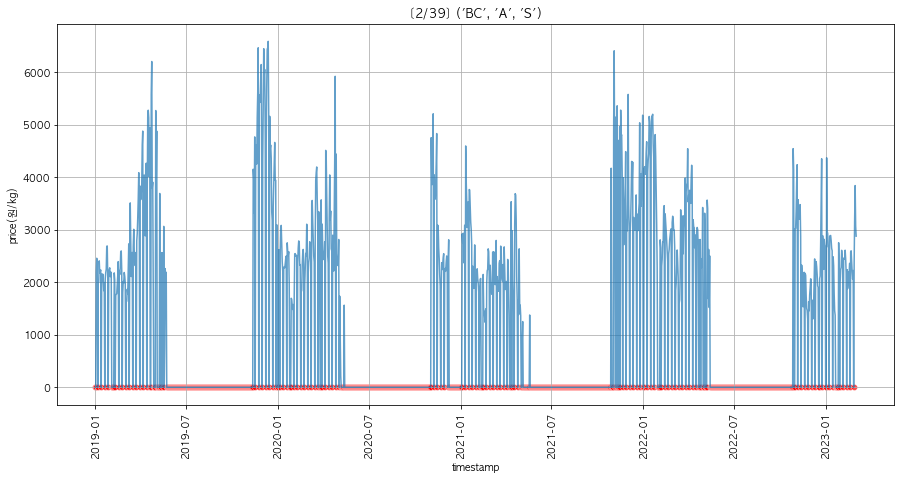

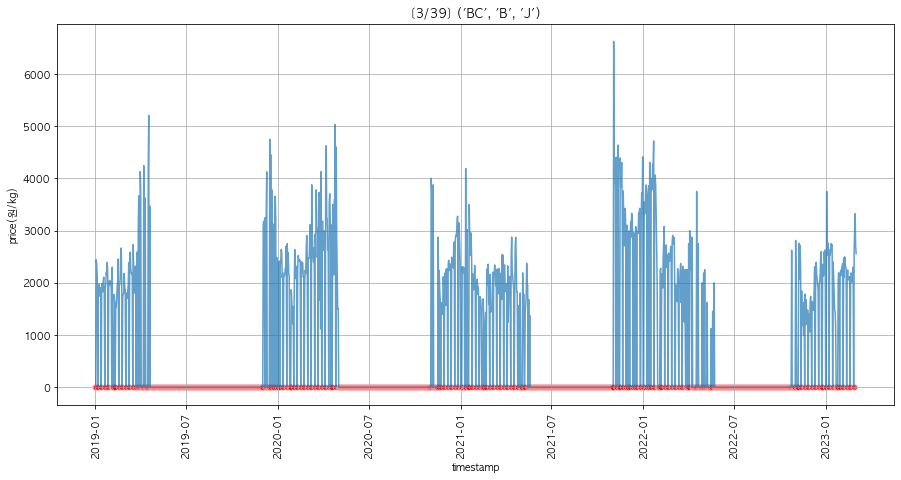

In [20]:
# (3) 품목/법인/지역에 따른 일별 가격변동
grp_data = train_df.groupby(CFG.KEY_FEATURES)
for i,(idx,d) in enumerate(grp_data):
    if i<3:
        plt.figure(figsize=(15,7))
        sns.lineplot(x=d['timestamp'],y=d[CFG.TARGET],alpha=0.7)
        if np.where(d[CFG.TARGET]==0,1,0).sum()>0:
            x=d['timestamp'][d[CFG.TARGET]==0]
            y=d[CFG.TARGET] [d[CFG.TARGET]==0]
            sns.scatterplot(x=x,y=y,color='red',alpha=0.7)
        plt.xticks(rotation=90)
        plt.grid()
        plt.title(f'[{i+1}/{len(grp_data)}] {idx}')
        plt.show()

<br></br>

# Modeling

In [21]:
from copy import deepcopy
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle

def RMSE(y_true,y_pred):
    return mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

class WeightedMSELoss:        
    def calc_ders_range(self, approxes, targets, weights):
        alpha = 5
        
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            residual = targets[index] - approxes[index]
            grad = -2 * alpha * residual if residual > 0 else -2 * residual
            hess = 2 * alpha if residual > 0 else 2.0
            
            if weights is not None:
                grad *= weights[index]
                hess *= weights[index]
            
            result.append((grad, hess))
        return result

In [31]:
# 2) 업데이트버전
#  (1) stacking 추가
#  (2) LGBM에 sample_weight 추가
class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hyperparameters,
                 weight='balanced',
                 inverse_transform=None,
                 eval_metric=None,
                 method='ensemble',
                 use_weightedsum_in_stacking=True):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        self.method = method
        self.use_weightedsum_in_stacking = use_weightedsum_in_stacking
        
        self._get_regressors()
        
        if use_weightedsum_in_stacking:
            self.stacking_feature = 'pred'
        else:
            self.stacking_feature = [f'pred{i+1}' for i in range(len(self.regressors))]
            
    def _get_regressors(self):
        max_depth = 9
        n_jobs = -1
        cat_loss_function = 'RMSE'
        cat_eval_metric = 'RMSE'
        lgb_metric = 'rmse' # 'rmse','mean_absolute_error'
        
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3, 
                                 random_state=self.hyperparameters['random_state']),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            #'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'SymmetricTree', # 'Lossguide','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost4 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Depthwise', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
    
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['xgb_iterations'],
            'early_stopping_rounds' : self.hyperparameters['xgb_early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['xgb_learning_rate'],
            'objective' : 'reg:squarederror',#'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm1 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm2 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm3 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm4 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm5 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm6 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm7 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm8 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['extratrees_iterations'],
            'criterion' : 'absolute_error',
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        self.regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            # ElasticNetCV(**params_elasticnet),
            CatBoostRegressor(**params_catboost1),
            CatBoostRegressor(**params_catboost2),
            CatBoostRegressor(**params_catboost3),
            CatBoostRegressor(**params_catboost4),
            # XGBRegressor(**params_xgboost),
            # LGBMRegressor(**params_lightgbm1),
            # LGBMRegressor(**params_lightgbm2),
            # LGBMRegressor(**params_lightgbm3),
            # LGBMRegressor(**params_lightgbm4),
            # LGBMRegressor(**params_lightgbm5),
            # LGBMRegressor(**params_lightgbm6),
            # LGBMRegressor(**params_lightgbm7),
            # LGBMRegressor(**params_lightgbm8),
            # ExtraTreesRegressor(**params_extratrees),
        ]
        
        self.stacking_regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            # ElasticNetCV(**params_elasticnet),
            # CatBoostRegressor(**params_catboost1),
            # CatBoostRegressor(**params_catboost2),
            # CatBoostRegressor(**params_catboost3),
            # CatBoostRegressor(**params_catboost4),
            # XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm1),
            LGBMRegressor(**params_lightgbm2),
            LGBMRegressor(**params_lightgbm3),
            LGBMRegressor(**params_lightgbm4),
            LGBMRegressor(**params_lightgbm5),
            LGBMRegressor(**params_lightgbm6),
            LGBMRegressor(**params_lightgbm7),
            LGBMRegressor(**params_lightgbm8),
            # ExtraTreesRegressor(**params_extratrees),
        ]
        
        self.regressors_name = [type(r).__name__ for r in self.regressors]
        self.stacking_regressors_name = [type(r).__name__ for r in self.stacking_regressors]
        
    def _get_ohe(self,X,cat_features):
        ohe = OneHotEncoder()
        ohe.fit(X,cat_features,remove_first=True)
        return ohe
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _preprocess(self,pred):
        pred = self._set_zero_to_minimum(pred,self.minimum_value)
        pred = self._set_inf_to_maximum(pred,self.maximum_value)
        return pred
    
    def _fit_regressor(self,
                       regressor,regressor_name,
                       X,X_oh,X_val,X_val_oh,y,y_val,cat_features,
                       sample_weight,eval_sample_weight):
        if regressor_name in ['LinearRegression','RidgeCV','LassoCV','ElasticNetCV','ExtraTreesRegressor']:
            warnings.filterwarnings("ignore", category=UserWarning)
            # fitting
            regressor.fit(X_oh,y)
            # prediction
            tr_pred = self._preprocess(regressor.predict(X_oh)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_oh).flatten())

        elif regressor_name=='XGBRegressor':
            # fitting
            regressor.fit(
                X_oh,y,
                eval_set=[(X_val_oh,y_val)],
                verbose=0,
            )
            # prediction
            tr_pred = self._preprocess(regressor.predict(X_oh)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_oh).flatten())

        elif regressor_name=='CatBoostRegressor':
            # dataset
            train_dataset = Pool(X    ,y    ,cat_features=cat_features)
            val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
            # fitting
            regressor.fit(
                train_dataset,
                eval_set=val_dataset,
                #metric_period=self.hyperparameters['iterations']//50, verbose=True,
                verbose=False,
            )
            # prediction
            tr_pred = self._preprocess(regressor.predict(train_dataset).flatten())
            va_pred = self._preprocess(regressor.predict(val_dataset)  .flatten())

        elif regressor_name=='LGBMRegressor':
            warnings.filterwarnings("ignore", category=UserWarning)
            # astype category
            X_tmp, X_val_tmp = X.copy(), X_val.copy()
            for col in cat_features:
                X_tmp[col]     = X_tmp[col]    .astype('category')
                X_val_tmp[col] = X_val_tmp[col].astype('category')
            # fitting
            regressor.fit(
                X_tmp,y,
                eval_set=[(X_val_tmp,y_val)],
                sample_weight=sample_weight,
                eval_sample_weight=eval_sample_weight,
                verbose=-1,
            )
            tr_pred = self._preprocess(regressor.predict(X_tmp)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_tmp).flatten())

        else:
            raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
        return regressor, tr_pred, va_pred
            
    def _get_prediction_values(self,X,X_oh,method,regressors_name,regressors,weights,return_weighted):
        if method=='ensemble':
            features    = self.features
            oh_features = self.oh_features
        elif method=='stacking':
            stacking_feature = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            features    = self.features + stacking_feature
            oh_features = self.oh_features + stacking_feature
        
        # (1) 예측값생성
        pred_list = []
        for regressor_name,regressor in zip(regressors_name,regressors):
            if regressor_name in ['LinearRegression','RidgeCV','LassoCV','ElasticNetCV','XGBRegressor','ExtraTreesRegressor']:
                dataset = X_oh[oh_features]
            elif regressor_name=='CatBoostRegressor':
                dataset = Pool(X[features],cat_features=self.cat_features)
            elif regressor_name=='LGBMRegressor':
                dataset = X[features].copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = self._preprocess(regressor.predict(dataset).flatten())
            pred_list.append(y_pred)
        
        # (2) return weighted or original value
        if return_weighted:
            final_pred = np.zeros(len(X))
            for pred,weight in zip(pred_list,weights):
                final_pred += np.array(pred)*weight
            if self.inverse_transform is not None:
                final_pred = self.inverse_transform(np.array(final_pred))
                final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
        else:
            final_pred = np.array(pred_list).T
            
        return final_pred
        
    def _predict(self,X,method='stacking',return_weighted=True):
        X_oh = self.ohe.transform(X)
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        assert method in ['ensemble','stacking'], \
            "method must be one of ['ensemble','stacking']"
        
        # (1) ensemble
        pred_list = self._get_prediction_values(
            X,X_oh,
            'ensemble',
            self.regressors_name,self.regressors,
            self.ensemble_weights,return_weighted,
        )
        
        if method=='ensemble':
            return pred_list
        
        elif method=='stacking':
            # (2) stacking
            columns = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            pred_df = pd.DataFrame(pred_list,columns=columns,index=X.index)
            
            X    = pd.concat([X   ,pred_df],axis=1)
            X_oh = pd.concat([X_oh,pred_df],axis=1)

            pred_list = self._get_prediction_values(
                X,X_oh,
                'stacking',
                self.stacking_regressors_name,self.stacking_regressors,
                self.stacking_weights,return_weighted,
            )
            return pred_list
            
    def fit(self,X,y,eval_set,cat_features,sample_weight=None,eval_sample_weight=None,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        
        self.sample_weight = sample_weight
        self.eval_sample_weight = eval_sample_weight
        self.cat_features = cat_features
        self.enable_categorical = [True if col in cat_features else False for col in X.columns]
        
        #----------------------------------------------------------------------------------------#
        # prepare dataset
        #----------------------------------------------------------------------------------------#
        X_val, y_val = eval_set[0]
        self.ohe = self._get_ohe(X,cat_features)
        X_oh = self.ohe.transform(X)
        X_val_oh = self.ohe.transform(X_val)
        
        del_cols = return_unique_columns(X)
        X.drop(del_cols,axis=1,inplace=True)
        X_val.drop(del_cols,axis=1,inplace=True)
        cat_features = list(set(cat_features)-set(del_cols))
        
        del_oh_cols = return_unique_columns(X_oh)
        X_oh.drop(del_oh_cols,axis=1,inplace=True)
        X_val_oh.drop(del_oh_cols,axis=1,inplace=True)
        
        #----------------------------------------------------------------------------------------#
        # save feature names
        #----------------------------------------------------------------------------------------#
        self.features    = X   .columns.tolist()
        self.oh_features = X_oh.columns.tolist()
        
        #----------------------------------------------------------------------------------------#
        # true value
        #----------------------------------------------------------------------------------------#
        tr_true = np.array(y)    .flatten()
        va_true = np.array(y_val).flatten()
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        #----------------------------------------------------------------------------------------#
        # set min,max value
        #----------------------------------------------------------------------------------------#
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        #----------------------------------------------------------------------------------------#
        # (1) ensemble fitting
        #----------------------------------------------------------------------------------------#
        # prepare ensemble fitting
        self.ensemble_scores = []
        self.ensemble_weights = []
        self.ensemble_fitting_elapsed = []
        ensemble_pbar = zip(self.regressors_name,self.regressors)

        # fitting
        if self.method=='stacking':
            if verbose:
                print('\n########  <Step1> Ensemble  ########')
        for fit_iter,(regressor_name,regressor) in enumerate(ensemble_pbar):
            s = time.time()
                
            # fit
            regressor, tr_pred, va_pred = self._fit_regressor(
                regressor, regressor_name,
                X, X_oh, X_val, X_val_oh, y, y_val, cat_features,
                sample_weight, eval_sample_weight,
            )
            self.regressors[fit_iter] = regressor
            
            # progress
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self.inverse_transform(va_pred)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
            
            tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
            va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)
            
            e = time.time()
            self.ensemble_scores.append(va_score)
            self.ensemble_weights.append(1/va_score)
            self.ensemble_fitting_elapsed.append(e-s)
            
            if verbose:
                blank = ' '*(11-len(regressor_name))
                fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                    .format(fit_iter+1,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
                print(fit_progress)
            
        # get weighted prediction & score
        if self.weight=='equal':
            self.ensemble_weights = np.array([1.0 for _ in self.regressors])
        self.ensemble_weights /= sum(self.ensemble_weights)
        
        tr_pred = self._predict(X,method='ensemble',return_weighted=True)
        va_pred = self._predict(X_val,method='ensemble',return_weighted=True)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
        ens_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)
        
        if verbose:
            ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                .format(self.weight,ens_tr_score,ens_va_score,sum(self.ensemble_fitting_elapsed))
            print(ens_fit_progress)
        
        if self.method=='ensemble':
            self.total_score = ens_va_score
            
        elif self.method=='stacking':
            #----------------------------------------------------------------------------------------#
            # (2) stacking fitting
            #----------------------------------------------------------------------------------------#
            tr_pred = self._predict(X,method='ensemble',return_weighted=self.use_weightedsum_in_stacking)
            va_pred = self._predict(X_val,method='ensemble',return_weighted=self.use_weightedsum_in_stacking)

            columns = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            tr_pred_df = pd.DataFrame(tr_pred,columns=columns,index=X.index)
            va_pred_df = pd.DataFrame(va_pred,columns=columns,index=X_val.index)
            
            X        = pd.concat([X       ,tr_pred_df],axis=1)
            X_oh     = pd.concat([X_oh    ,tr_pred_df],axis=1)
            X_val    = pd.concat([X_val   ,va_pred_df],axis=1)
            X_val_oh = pd.concat([X_val_oh,va_pred_df],axis=1)

            # prepare stacking fitting
            self.stacking_scores = []
            self.stacking_weights = []
            self.stacking_fitting_elapsed = []

            stacking_regressors = deepcopy(self.stacking_regressors)
            stacking_pbar =  zip(self.stacking_regressors_name,stacking_regressors)

            if verbose:
                print('\n########  <Step2> Stacking  ########')
            self.stacking_regressors = []
            for fit_iter,(regressor_name,regressor) in enumerate(stacking_pbar):
                s = time.time()

                # fitting
                stacking_regressor, tr_pred, va_pred = self._fit_regressor(
                    regressor, regressor_name,
                    X, X_oh, X_val, X_val_oh, y, y_val, cat_features,
                    sample_weight, eval_sample_weight,
                )
                self.stacking_regressors.append(stacking_regressor)

                # progress
                if self.inverse_transform is not None:
                    tr_pred = self.inverse_transform(tr_pred)
                    tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                    va_pred = self.inverse_transform(va_pred)
                    va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)

                tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
                va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)

                e = time.time()
                self.stacking_scores.append(va_score)
                self.stacking_weights.append(1/va_score)
                self.stacking_fitting_elapsed.append(e-s)

                if verbose:
                    blank = ' '*(11-len(regressor_name))
                    fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                        .format(fit_iter+1,len(stacking_regressors),regressor_name,blank,tr_score,va_score,e-s)
                    print(fit_progress)

            # get weighted prediction & score
            if self.weight=='equal':
                self.stacking_weights = np.array([1.0 for _ in self.stacking_regressors])
            self.stacking_weights /= sum(self.stacking_weights)

            tr_pred = self._predict(
                X   .drop(self.stacking_feature,axis=1),
                X_oh.drop(self.stacking_feature,axis=1),
                method='stacking',
            )
            va_pred = self._predict(
                X_val   .drop(self.stacking_feature,axis=1),
                X_val_oh.drop(self.stacking_feature,axis=1),
                method='stacking',
            )

            ## -> self.predict에서 inverse_transform 해줌
            # if self.inverse_transform is not None:
            #     tr_pred = self.inverse_transform(tr_pred)
            #     va_pred = self.inverse_transform(va_pred)

            stacking_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
            stacking_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)

            if verbose:
                stacking_fit_progress = "<Weighted Stacking(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                    .format(self.weight,stacking_tr_score,stacking_va_score,sum(self.stacking_fitting_elapsed))
                print(stacking_fit_progress)

            self.total_score = stacking_va_score
            
        self.feature_importances_ = self.get_feature_importance()['importance'].values.tolist()

    def predict(self,X,method=None):
        X_oh = self.ohe.transform(X)
        if method is None:
            method = self.method
        if (self.method=='ensemble') & (method=='stacking'):
            raise ValueError("The training method is 'ensemble', so 'stacking' prediction is not possible")
        return self._predict(X,method=self.method,return_weighted=self.use_weightedsum_in_stacking)
    
    def get_feature_importance(self):
        # feature_importances_를 지원하는 모델들
        supported_models = ['CatBoostRegressor','XGBRegressor','LGBMRegressor','ExtraTreesRegressor']
        
        # 지원하지않는 모델이 있는 경우 warning message
        not_supported = [n for n in self.regressors_name if n not in supported_models]
        if len(not_supported)>0:
            warnings.warn("not support model: {}".format(not_supported))

        # get weighted feature importance by using ensemble_weights
        feature_importance_df = pd.DataFrame(self.features,columns=['feature'])
        for i,(regressor,regressor_name,weight) in enumerate(zip(self.regressors,self.regressors_name,self.ensemble_weights)):
            if regressor_name in supported_models:
                feature_importance = regressor.feature_importances_
                fi_list = []
                for feature in self.features:
                    fi = feature_importance[np.where(np.array(self.features)==feature)[0]]
                    fi_list.append([feature,sum(fi)])

                imp_col = f'importance{i}'
                fi_df = pd.DataFrame(fi_list,columns=['feature',imp_col]).sort_values(imp_col,ascending=False)
                fi_df[imp_col] = 100 * fi_df[imp_col] / fi_df[imp_col].sum()
                fi_df[imp_col] *= weight

                feature_importance_df = pd.merge(feature_importance_df,fi_df,how='left',on='feature')

        feature_importance_df = feature_importance_df.fillna(0)
        feature_importance_df['importance'] = feature_importance_df.drop('feature',axis=1).sum(axis=1)
        feature_importance_df = feature_importance_df[['feature','importance']]
        
        return feature_importance_df
    
    def plot_feature_importance(self):
        feature_importance_df = self.get_feature_importance()
        feature_importance_df.sort_values('importance',ascending=True,inplace=True)
        plt.figure(figsize=(15,7))
        plt.barh(feature_importance_df['feature'],feature_importance_df['importance'])
        plt.show()
        
    def save_model(self,path):
        save_dict = {
            'ohe' : self.ohe,
            'cat_features' : self.cat_features,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'sample_weight' : self.sample_weight,
            'eval_sample_weight' : self.eval_sample_weight,
            
            'regressors' : self.regressors,
            'ensemble_weights' : self.ensemble_weights,
            'ensemble_fitting_elapsed' : self.ensemble_fitting_elapsed,
            'ensemble_scores' : self.ensemble_scores,
            
            'total_score' : self.total_score,
        }
        if self.method=='stacking':
            additional_save_dict = {
                'stacking_regressors' : self.stacking_regressors,
                'stacking_weights' : self.stacking_weights,
                'stacking_fitting_elapsed' : self.stacking_fitting_elapsed,
                'stacking_scores' : self.stacking_scores,
            }
            save_dict = {**save_dict,**additional_save_dict}
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.ohe = save_dict['ohe']
            self.cat_features = save_dict['cat_features']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.sample_weight = save_dict['sample_weight']
            self.eval_sample_weight = save_dict['eval_sample_weight']
            
            self.regressors = save_dict['regressors']
            self.ensemble_weights = save_dict['ensemble_weights']
            self.ensemble_fitting_elapsed = save_dict['ensemble_fitting_elapsed']
            self.ensemble_scores = save_dict['ensemble_scores']
            
            self.total_score = save_dict['total_score']
            
            if self.method=='stacking':
                self.stacking_regressors = save_dict['stacking_regressors']
                self.stacking_weights = save_dict['stacking_weights']
                self.stacking_fitting_elapsed = save_dict['stacking_fitting_elapsed']
                self.stacking_scores = save_dict['stacking_scores']

In [32]:
class KfoldWeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hyperparameters,
                 method='ensemble',
                 weight='balanced',
                 inverse_transform=None,
                 eval_metric=None,
                 use_ensemble=True,
                 n_splits=5,
                 random_state=0):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.method = method
        self.weight = weight
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        self.use_ensemble = use_ensemble
        self.n_splits = n_splits
        self.random_state = random_state
        
    def fit(self,X,y,cat_features,sample_weight=None,verbose=True):
        self.cat_features = cat_features
        self.sample_weight = sample_weight

        self.base_models = []
        self.base_scores = []
        self.base_feature_importances = []
        kf = KFold(n_splits=self.n_splits,random_state=self.random_state,shuffle=True)

        progress_fmt = '> KFold: {}/{}'
        for k, (tr_idx, val_idx) in enumerate(kf.split(X)):
            k_str = str(k+1).zfill(len(str(self.n_splits)))
            print('')
            print('-'*80)
            print(progress_fmt.format(k_str,self.n_splits))
            print('-'*80)
            
            X_tr   , X_va    = X   .iloc[tr_idx], X   .iloc[val_idx]
            y_tr   , y_va    = y   .iloc[tr_idx], y   .iloc[val_idx]
            
            if self.sample_weight is None:
                sample_weight = None
                eval_sample_weight = None
            else:
                sample_weight = self.sample_weight[tr_idx]
                eval_sample_weight = self.sample_weight[val_idx]

            #------------------------------------------------------------------------------------#
            # (1) base model
            #------------------------------------------------------------------------------------#
            # define the base model
            base_model = WeightedEnsembleRegressor(
                hyperparameters=hyperparameters,
                method=self.method, # 'ensemble', 'stacking'
                weight='balanced', # 'equal', 'balanced',
                inverse_transform=self.inverse_transform,
                use_weightedsum_in_stacking=True,
            )
            # fit the model
            base_model.fit(
                X_tr,y_tr,
                eval_set=[(X_va,y_va)],
                cat_features=cat_features,
                sample_weight=sample_weight,
                eval_sample_weight=[eval_sample_weight],
                verbose=verbose,
            )
            
            # prediction
            y_pred = base_model.predict(X_va).flatten()
            if self.inverse_transform is not None:
                y_true = self.inverse_transform(y_va.values)
            else:
                y_true = y_va.values.flatten()
            
            # caculate score
            score = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

            # append inner loop
            self.base_models.append(base_model)
            self.base_scores.append([k+1,len(X_tr),len(X_va),score])
            self.base_feature_importances.append(base_model.feature_importances_)
            
            # plot feature importance
            base_model.plot_feature_importance()
        
        self.base_score = pd.DataFrame(self.base_scores,columns=['k','n_train','n_val','rmse'])
        self.validation_score = self.base_score.rmse.mean()
        
    def predict(self,X):
        pred = [base_model.predict(X) for base_model in self.base_models]
        pred = np.mean(pred,axis=0)
        return pred
    
    def save_model(self,path):
        save_dict = {
            'hyperparameters' : self.hyperparameters,
            'weight' : self.weight,
            'n_splits' : self.n_splits,
            'random_state' : self.random_state,
            'inverse_transform' : self.inverse_transform,
            'cat_features' : self.cat_features,
            'sample_weight' : self.sample_weight,
            'base_models' : self.base_models,
            'base_scores' : self.base_scores,
            'base_score' : self.base_score,
            'validation_score' : self.validation_score,
            'base_feature_importances' : self.base_feature_importances,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            
            self.hyperparameters = save_dict['hyperparameters']
            self.weight = save_dict['weight']
            self.n_splits = save_dict['n_splits']
            self.random_state = save_dict['random_state']
            self.inverse_transform = save_dict['inverse_transform']
            self.cat_features = save_dict['cat_features']
            self.sample_weight = save_dict['sample_weight']
            self.base_models = save_dict['base_models']
            self.base_scores = save_dict['base_scores']
            self.base_score = save_dict['base_score']
            self.validation_score = save_dict['validation_score']
            self.base_feature_importances = save_dict['base_feature_importances']

In [33]:
hyperparameters = {
    'n_splits' : CFG.N_SPLITS,
    'max_depth' : 9,
    'random_state' : CFG.SEED,
    'learning_rate' : 0.01,
    'iterations' : 30000,
    'early_stopping_rounds' : 300,
    'xgb_learning_rate' : 0.3,         # default=0.3
    'xgb_iterations' : 3000,           # default=100
    'xgb_early_stopping_rounds' : 30,
    'extratrees_iterations' : 100,     # default=100
}

In [34]:
# prepare dataset
y = train_df[CFG.TARGET]

X      = train_df.drop(CFG.TARGET,axis=1)
X_test = test_df.copy()

X     .drop('timestamp',axis=1,inplace=True)
X_test.drop('timestamp',axis=1,inplace=True)

cat_features = CFG.KEY_FEATURES

In [35]:
mkdir('./mc')
save_model_path = './mc/weiens.pickle'


--------------------------------------------------------------------------------
> KFold: 1/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=661.561, val_loss=864.436, elasped=73.5s
[2/4] CatBoostRegressor: loss=708.951, val_loss=869.423, elasped=91.5s
[3/4] CatBoostRegressor: loss=719.221, val_loss=871.301, elasped=118.6s
[4/4] CatBoostRegressor: loss=606.659, val_loss=861.253, elasped=61.1s
<Weighted Ensemble(weight='balanced')> loss=669.815, val_loss=862.736, elasped=344.6s


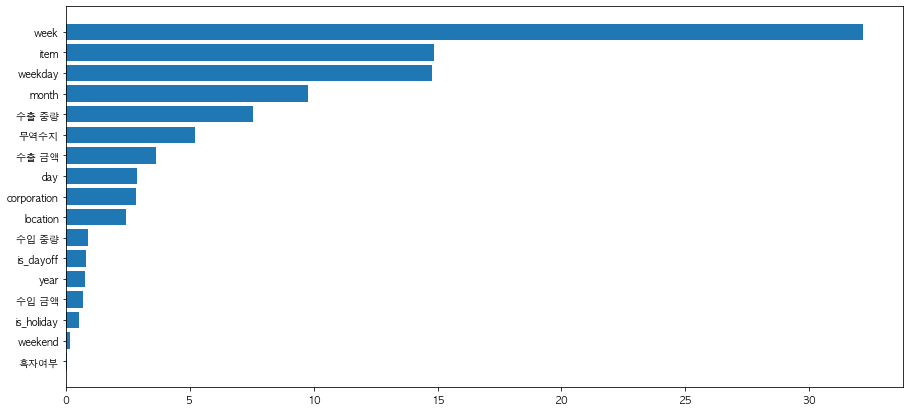


--------------------------------------------------------------------------------
> KFold: 2/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=704.326, val_loss=814.652, elasped=65.2s
[2/4] CatBoostRegressor: loss=673.027, val_loss=811.434, elasped=192.2s
[3/4] CatBoostRegressor: loss=726.078, val_loss=811.450, elasped=133.9s
[4/4] CatBoostRegressor: loss=641.569, val_loss=805.011, elasped=67.2s
<Weighted Ensemble(weight='balanced')> loss=681.898, val_loss=806.234, elasped=458.6s


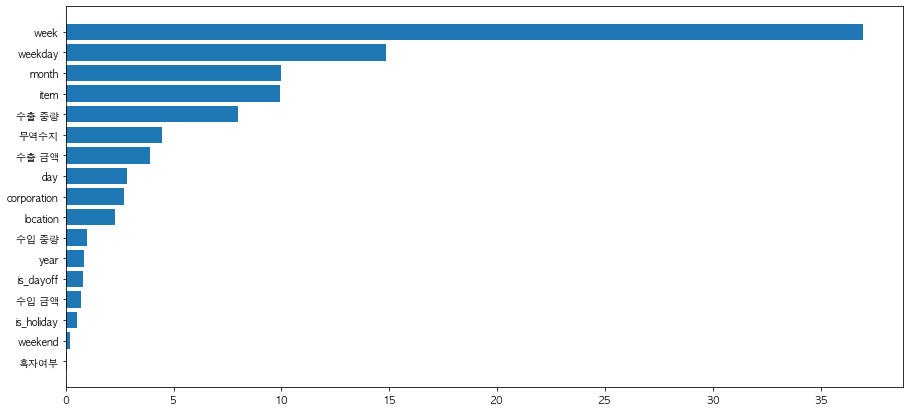


--------------------------------------------------------------------------------
> KFold: 3/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=681.472, val_loss=856.624, elasped=94.3s
[2/4] CatBoostRegressor: loss=698.415, val_loss=855.065, elasped=114.2s
[3/4] CatBoostRegressor: loss=723.680, val_loss=862.601, elasped=147.0s
[4/4] CatBoostRegressor: loss=616.238, val_loss=845.543, elasped=60.2s
<Weighted Ensemble(weight='balanced')> loss=675.677, val_loss=850.995, elasped=415.7s


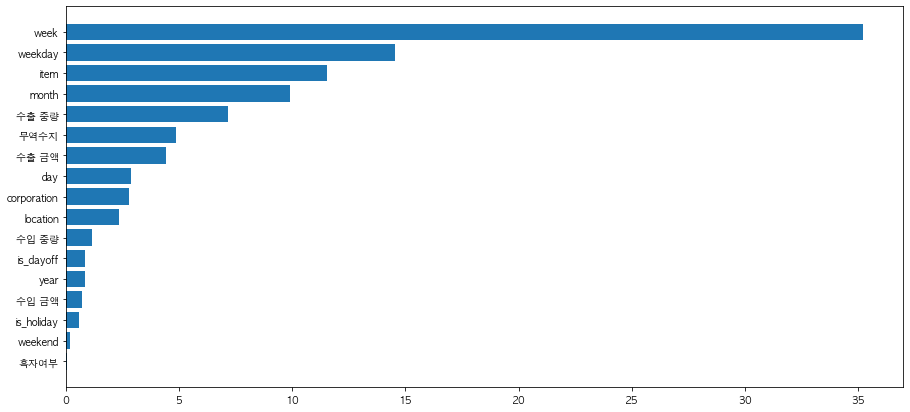


--------------------------------------------------------------------------------
> KFold: 4/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=645.981, val_loss=855.795, elasped=88.6s
[2/4] CatBoostRegressor: loss=672.307, val_loss=862.332, elasped=130.8s
[3/4] CatBoostRegressor: loss=719.277, val_loss=865.136, elasped=123.0s
[4/4] CatBoostRegressor: loss=604.830, val_loss=847.925, elasped=62.3s
<Weighted Ensemble(weight='balanced')> loss=656.229, val_loss=853.384, elasped=404.7s


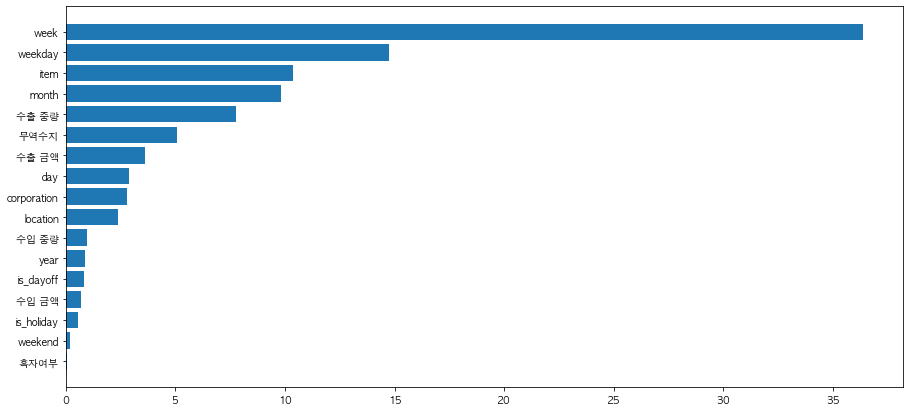


--------------------------------------------------------------------------------
> KFold: 5/5
--------------------------------------------------------------------------------
[1/4] CatBoostRegressor: loss=696.031, val_loss=828.779, elasped=57.8s
[2/4] CatBoostRegressor: loss=714.659, val_loss=829.692, elasped=87.4s
[3/4] CatBoostRegressor: loss=745.840, val_loss=832.693, elasped=81.9s
[4/4] CatBoostRegressor: loss=661.857, val_loss=826.719, elasped=44.4s
<Weighted Ensemble(weight='balanced')> loss=701.034, val_loss=826.081, elasped=271.6s


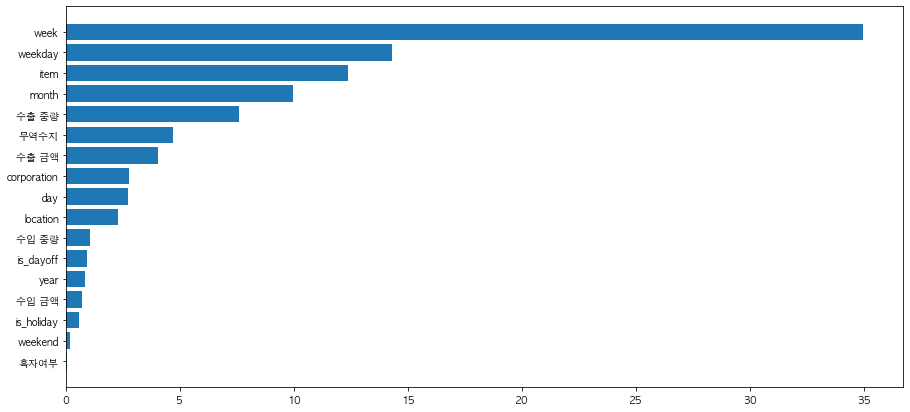

CPU times: user 1h 44min 32s, sys: 32min 54s, total: 2h 17min 26s
Wall time: 31min 54s


In [36]:
%%time

model = KfoldWeightedEnsembleRegressor(
    hyperparameters,
    method='ensemble',
    weight='balanced',
    inverse_transform=None,#target_transform.inverse_transform,
    eval_metric=None,
    use_ensemble=True,
    n_splits=CFG.N_SPLITS,
    random_state=CFG.SEED,
)
model.fit(
    X,y,
    cat_features=cat_features,
    sample_weight=None,
    verbose=True,
)
model.save_model(save_model_path)

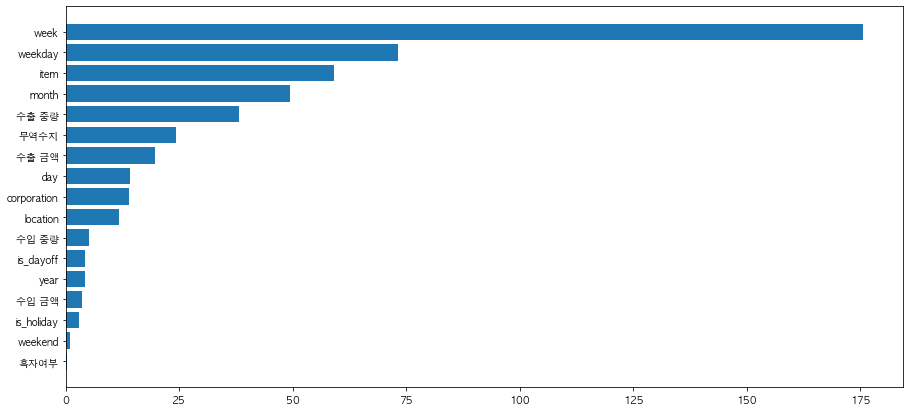

In [48]:
imp_df = pd.DataFrame({
    'feature' : X.columns,
    'importance' : np.sum(model.base_feature_importances,axis=0),
}).sort_values('importance',ascending=True)

plt.figure(figsize=(15,7))
plt.barh(imp_df.feature,imp_df.importance)
plt.show()

In [54]:
submit = pd.read_csv('./data/sample_submission.csv')
submit['answer'] = model.predict(X_test)
submit.to_csv('./out/submit_1.csv',index=False)
submit.head()

,ID,answer
0,TG_A_J_20230304,3436.538467
1,TG_A_J_20230305,437.026424
2,TG_A_J_20230306,3625.485586
3,TG_A_J_20230307,3586.354048
4,TG_A_J_20230308,3548.919734
